# Training (fc layer only with dataframe)

## Set up

### Package imports

In [1]:
# Import packages
import re
import os
import gc
import copy
from pathlib import Path
import numpy as np
from numpy.random import MT19937
from numpy.random import RandomState, SeedSequence
import pandas as pd
import math
import random
import datetime
import time
import warnings
from pdb import set_trace
from collections import Counter

import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.cm as cm
import matplotlib.lines as mlines
import matplotlib.patches as mpatches
from matplotlib.ticker import MaxNLocator
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, precision_score, recall_score, f1_score, matthews_corrcoef
from sklearn.preprocessing import LabelEncoder, StandardScaler

import torch
from torch import nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.utils.data import Dataset, DataLoader, Sampler
from torchvision import models, transforms

### GPU

In [2]:
#Check to see if the GPU is available and store it as a variable so tensors can be moved to it
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)
print('Is cuda available?:', torch.cuda.is_available())
print('cuda version:', torch.version.cuda)
dev = "cuda:0"

Using device: cuda
Is cuda available?: True
cuda version: 12.4


### Variables and Hyperparameters

In [3]:
# Create a timestamp for the summary file name
Time_Stamp = datetime.datetime.now().strftime("%Y_%m%d%_H%M")

# Create run name
Run_Name = '0411; protein; FC only' # change run_name before running

# Paths
raw_folder_path = '/home/ec2-user/Feb2025/raw_datasets/' # raw dataset folder with all the proteome and mRNA data
label_path = '/home/ec2-user/Feb2025/labels/' # label folder with all the labels
dataset_folder_path = '/home/ec2-user/Feb2025/processed_dataset2/' # dataset folder with all the processed proteome and mRNA data
fig_bank_path = '/home/ec2-user/Feb2025/figure_bank/'
model_folder_path = '/home/ec2-user/Feb2025/saved_models/' # model folder with all the models
# Define the Model
Model = 'FConly'

# Define loss function
LossFunc_Name = 'Focal' # 'CrossEntropy', 'Focal' are the options

# Define the optimizer
Optim_Name = 'AdamW' # 'Adam', 'AdamW', 'SGD', 'SGD_weight' are the options

# Dataset
Set = 'mRNA' # Define the dataset to use, 'Protein', 'mRNA', 'Protein + mRNA', or 'Protein + mRNA Stack' are the options

# Seed number
Seed = 43

# Validation fraction
Validation_Fraction = 0.15

# Standard deviation for add-noise transformation
StandardDeviation = 0.05

# Learning rate scheduler
LrScheduler = True
Learner_rate = 1e-4

# Optimizer
Weight_Decay = 0.0001 # L2 regulator
#  it works by adding a penalty to the loss function, which discourages large weights in the model; penalizes for too many weights - helps prevent overfitting
#  the penalty is calculated as weight_decay * weight^2, and it's added to the loss.
#  1e-4 or 1e-3 gives higher acc

# Loss Function (CrossEntropyLoss)
Label_Smoothing = 0.1
#  sets the target of the loss function to something greater than 0 and less than 1
#  helps prevent overfitting

# Early stopping
Earlystopping = False

# Transformation
TransformOrNot = True

# Class weight to loss function
ApplyClassWeightToLoss = True
#  makes the loss weights equal to the fraction of each category label
#  note, a layer is added to the model so the outputs of the model are equal to the number of categories

# Batch size
Batch_size = 64

# Epoch amount
epochs = 200

### Protein, mRNA dataframe, localization label set up

In [4]:
# Open the proteomics data and only keep genes (rows) that are fully quantified
PFP = 'K_PD_synthetic_kde_qttumor.csv' # synthetic data
PD = pd.read_csv(dataset_folder_path+PFP)

# Data set wrangling
PD.index = PD.loc[:,'Index']
PD = PD.loc[:,PD.columns!='Index']
PD.dropna(inplace=True)

# Open the mRNA data and only keep genes (rows) that are fully quantified
MFP = 'K_MD_synthetic_kde_qttumor.csv'
MD = pd.read_csv(dataset_folder_path + MFP)

# Data set wrangling
MD.index = MD.loc[:,'Index']
MD = MD.loc[:,MD.columns!='Index']
MD = MD.drop_duplicates()
MD.dropna(inplace=True)

In [5]:
# Open the labels data
#LFP = 'SubCellBarcode.MCF7.txt'
LFP = 'markers_mcf7_all.txt'
LD = pd.read_csv(filepath_or_buffer=label_path+LFP,sep='\t')
# Data set wrangling
LD.index = LD.loc[:,'Protein']
LD = LD.loc[:,LD.columns!='Protein']

In [6]:
# Extract the common indices between the proteomics and mRNA data
common_indices = list(set(PD.index).intersection(set(MD.index)))
LD = LD.loc[LD.index.isin(common_indices)]

print('Number of total labels in Krug dataset')
print(len(LD.index))
print(LD.value_counts())

Number of total labels in Krug dataset
6444
Localization
Cytosol         2825
Nucleus         1828
Secretory       1308
Mitochondria     483
Name: count, dtype: int64


### Set seed function

In [7]:
def set_seed(seed):
    random.seed(seed) # set random seed for python
    np.random.seed(seed) # set random seed for numpy
    torch.manual_seed(seed) # set random seed for CPU
    rs = RandomState(MT19937(SeedSequence(seed))) # seed for numpy
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed) # set random seed for all GPUs
    torch.backends.cudnn.deterministic = True # set to True to get reproducible results
    torch.backends.cudnn.benchmark = False # set to False to get reproducible results

### Transformation

In [8]:
# Custom transformation to add noise to the data
class AddNoise:
    def __init__(self, set, mean=0, std=0.05):
        self.set = set
        self.mean = mean
        self.std = std

    def __call__(self, array1, array2):
        if self.set == 'Protein + mRNA':
            noise1 = np.random.normal(self.mean, self.std, array1.shape)
            noise2 = np.random.normal(self.mean, self.std, array2.shape)

            return array1 + noise1, array2 + noise2    

        else: # suitable for Protein or mRNA only because same noise will be applied twice
            noise = np.random.normal(self.mean, self.std, array1.shape)
        
        return array1 + noise, array2 + noise

### Custom Dataset Class

In [9]:
class OmicsDatasetDual(Dataset):
    # __init__ will be run whenever we create a new instance of the class
    def __init__(self, set, data1, data2, indices, labels, transform=None):

        assert data1.loc[indices,:].shape[0] == data2.loc[indices,:].shape[0] == len(labels), \
            "Protein, mRNA, and labels must have the same number of samples (rows)"

        self.set = set
        self.data1 = data1.loc[indices,:] 
        self.data2 = data2.loc[indices,:]
        self.indices = indices
        self.labels = labels
        self.transform = transform

    # __len__ will be run whenever we call len() on the dataset
    def __len__(self):
        return len(self.labels)

    # __getitem__ will be run when we call an index on the dataset, i.e. dataset[0]
    def __getitem__(self, idx):
        data1 = self.data1.iloc[idx].values
        data2 = self.data2.iloc[idx].values

        if self.transform:
            data1, data2 = self.transform(data1, data2)
        
        abundance_sum = data1 + data2
        sorted_idx = abundance_sum.argsort()

        # Interleave
        interleaved_data = np.empty((len(data1) + len(data2)), dtype=np.float32)
        interleaved_data[0::2] = data1[sorted_idx]
        interleaved_data[1::2] = data2[sorted_idx]

        sample = torch.tensor(interleaved_data, dtype=torch.float32)
        label = torch.tensor(self.labels[idx], dtype=torch.long)  # Convert label to a tensor

        return sample, label

## Model training

### Labels to integers

In [10]:
# Labels
localization_labels = LD.loc[:, 'Localization'].values
unique_labels = set(localization_labels)  # Get unique labels
label_to_int = {
    'Cytosol': 0,
    'Mitochondria': 1,
    'Nucleus': 2,
    'Secretory': 3
}
int_to_label = {v: k for k, v in label_to_int.items()}
int_to_label

{0: 'Cytosol', 1: 'Mitochondria', 2: 'Nucleus', 3: 'Secretory'}

### Train Validation split

In [11]:
# Set seed to ensure reproducibility
set_seed(Seed)

# Split the columns (genes) into training and validation sets
train_indices, val_indices, train_labels, val_labels = train_test_split(LD.index, 
                                                                  localization_labels, 
                                                                  test_size=Validation_Fraction, 
                                                                  random_state=42, 
                                                                  stratify=localization_labels
)

# Convert string labels to integers
train_labels = [label_to_int[label] for label in train_labels]
val_labels = [label_to_int[label] for label in val_labels]


# Define the transformation
transformation = AddNoise(Set, mean=0, std=0.05)

# Create the training and validation datasets    
if Set == 'Protein':
    train_dataset = OmicsDatasetDual(Set, PD, PD, train_indices, train_labels, transform=transformation)
    val_dataset = OmicsDatasetDual(Set, PD, PD, val_indices, val_labels)
elif Set == 'mRNA':
    train_dataset = OmicsDatasetDual(Set, MD, MD, train_indices, train_labels, transform=transformation)
    val_dataset = OmicsDatasetDual(Set, MD, MD, val_indices, val_labels)
elif Set == 'Protein + mRNA':
    train_dataset = OmicsDatasetDual(Set, PD, MD, train_indices, train_labels, transform=transformation)
    val_dataset = OmicsDatasetDual(Set, PD, MD, val_indices, val_labels)
else:
    raise ValueError("Invalid dataset selection. Choose 'Protein', 'mRNA', 'Protein + mRNA'.")
# Create the data loaders
train_loader = DataLoader(train_dataset, batch_size=Batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=Batch_size, shuffle=False)

### Check data in loaders

In [12]:
# Train loader is a Pytorch DataLoader object and is iterable, but not subscriptable
for batch_data, batch_labels in train_loader:
    for i in range(1):
        # Grab the first data point and its label from the batch
        data_point = batch_data[i]  # First data point in the batch
        label = batch_labels[i]     # Corresponding label
        print("Data point:", data_point)
        print("Data point length:", len(data_point))
        print("Data point shape:", data_point.shape)
        print("Label:", label)
    break  # Exit after grabbing the first batch

Data point: tensor([-0.0182, -0.0182, -0.0124, -0.0124, -0.0034, -0.0034, -0.0023, -0.0023,
        -0.0012, -0.0012,  0.0021,  0.0021,  0.0028,  0.0028,  0.0125,  0.0125,
         0.0135,  0.0135,  0.0165,  0.0165,  0.0167,  0.0167,  0.0191,  0.0191,
         0.0195,  0.0195,  0.0255,  0.0255,  0.0261,  0.0261,  0.0360,  0.0360,
         0.0422,  0.0422,  0.0482,  0.0482,  0.0594,  0.0594,  0.0648,  0.0648,
         0.0665,  0.0665,  0.0776,  0.0776,  0.0805,  0.0805,  0.0884,  0.0884,
         0.0903,  0.0903,  0.1012,  0.1012,  0.1068,  0.1068,  0.1088,  0.1088,
         0.1096,  0.1096,  0.1119,  0.1119,  0.1137,  0.1137,  0.1216,  0.1216,
         0.1228,  0.1228,  0.1303,  0.1303,  0.1309,  0.1309,  0.1331,  0.1331,
         0.1363,  0.1363,  0.1463,  0.1463,  0.1497,  0.1497,  0.1525,  0.1525,
         0.1574,  0.1574,  0.1645,  0.1645,  0.1764,  0.1764,  0.1793,  0.1793,
         0.1832,  0.1832,  0.1842,  0.1842,  0.1850,  0.1850,  0.1924,  0.1924,
         0.1950,  0.1950,  0

In [13]:
# Check the distribution of labels in the training and validation dataset
train_label_counts = Counter(train_labels)
val_label_counts = Counter(val_labels)
print("Training set label distribution:")
print(train_label_counts)
print("Validation set label distribution:")
print(val_label_counts)

Training set label distribution:
Counter({0: 2401, 2: 1554, 3: 1112, 1: 410})
Validation set label distribution:
Counter({0: 424, 2: 274, 3: 196, 1: 73})


### Define model

In [14]:
# Define the fully connected neural network
class FullyConnectedNN(nn.Module):
    def __init__(self, input_size, hidden_size1, hidden_size2, hidden_size3, output_size):
        super(FullyConnectedNN, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size1)  # First hidden layer
        self.fc2 = nn.Linear(hidden_size1, hidden_size2)  # Second hidden layer
        self.fc3 = nn.Linear(hidden_size2, hidden_size3)  # Output layer
        self.fc4 = nn.Linear(hidden_size3, output_size)  # Output layer
        #self.softmax = nn.Softmax(dim=1)  # Softmax activation for output layer

    def forward(self, x):
        x = torch.relu(self.fc1(x))  # Apply ReLU activation to the first layer
        x = torch.relu(self.fc2(x))  # Apply ReLU activation to the second layer
        x = torch.relu(self.fc3(x))
        x = self.fc4(x)  # Output layer (logits)
        #x = self.softmax(x)  # Apply softmax to get probabilities
        return x

# Define the model
input_size = len(train_loader.dataset[0][0])  # Number of input features
hidden_size1 = 128  # Number of neurons in the first hidden layer
hidden_size2 = 64  # Number of neurons in the second hidden layer
hidden_size3 = 32  # Number of neurons in the third hidden layer
output_size = 4  # Number of output classes

model = FullyConnectedNN(input_size, hidden_size1, hidden_size2, hidden_size3, output_size)
model.to(dev)  # Move the model to the GPU if available

FullyConnectedNN(
  (fc1): Linear(in_features=324, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=32, bias=True)
  (fc4): Linear(in_features=32, out_features=4, bias=True)
)

### Define train loop

In [15]:
def train_loop(dataloader, model, loss_fn, optimizer):
    
    model.train()  # Set the model to training mode
    
    running_loss = 0.0
    correct_train = 0
    total_train = 0

    for X, y in dataloader:

        X = X.to(torch.float32)
        y = y.to(torch.long)

        # Move data and labels to the same device as the model (e.g., GPU if available)
        X = X.to(device)
        y = y.to(device)

        # Zero the gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(X)

        # Compute the loss
        loss = criterion(outputs, y)

        # Backward pass
        loss.backward()

        # Update weights
        optimizer.step()

        # Accumulate the loss
        running_loss += loss.item()

        # Compute training accuracy
        _, predicted = torch.max(outputs, 1)  # Get the class with the highest probability
        correct_train += (predicted == y).sum().item()
        total_train += y.size(0)

    # Calculate average training loss and accuracy
    avg_training_loss = running_loss / len(train_loader)
    training_accuracy = correct_train / total_train

    return avg_training_loss, training_accuracy


### Define test loop

In [16]:
def test_loop(dataloader, model, loss_fn):
    
    model.eval()  # Set the model to evaluation mode

    test_loss = 0.0
    correct = 0
    total = 0

    y_pred = []
    y_true = []
    
    with torch.no_grad():  # Disable gradient calculation
        for X, y in dataloader:
            
            # Prepare data
            X = X.to(torch.float32)
            y = y.to(torch.long)

            # Move data to GPU
            X = X.to(device)
            y = y.to(device)

            # Forward pass: predict classes
            outputs = model(X)
            
            # Compute the loss
            test_loss += loss_fn(outputs, y).item()

            # Get the predicted class
            _, predicted = torch.max(outputs, 1) 
            
            # Store predictions and true labels
            y_pred.extend(predicted.cpu().numpy())
            y_true.extend(y.cpu().numpy())

            # Count correct predictions
            correct += (predicted == y).sum().item() 

            # Count total predictions
            total += y.size(0) 

    # Calculate precision and recall for each class
    precision = precision_score(y_true, y_pred, average=None, zero_division=0.0)
    recall = recall_score(y_true, y_pred, average=None, zero_division=0.0)
    macro_f1 = f1_score(y_true, y_pred, average='macro')
    mcc = matthews_corrcoef(y_true, y_pred)

    avg_test_loss = test_loss / len(dataloader)
    test_accuracy = correct / total
        
    return avg_test_loss, test_accuracy, precision, recall, macro_f1, mcc

### Focal loss

In [17]:
class FocalLoss(nn.Module):
    def __init__(self, alpha=None, gamma=2.0, reduction='mean'):
        """
        alpha: tensor of class weights (e.g., inverse class frequency), shape (C,)
        gamma: focusing parameter (default 2.0)
        reduction: 'mean', 'sum', or 'none'
        """
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.reduction = reduction

    def forward(self, logits, targets):
        ce_loss = F.cross_entropy(logits, targets, weight=self.alpha, reduction='none')  # shape: (N,)
        pt = torch.exp(-ce_loss)  # pt = softmax prob of true class
        focal_loss = ((1 - pt) ** self.gamma) * ce_loss  # focal modulation

        if self.reduction == 'mean':
            return focal_loss.mean()
        elif self.reduction == 'sum':
            return focal_loss.sum()
        else:
            return focal_loss

### Training and validation

In [18]:
set_seed(Seed)

# Compute class weights
def compute_class_weights(class_counts): # inverse square root frequency for mild imbalance
    class_weights = 1.0 / torch.sqrt(torch.tensor(class_counts, dtype=torch.float))
    return class_weights / class_weights.sum()

# Given class counts
class_counts = [2414, 402, 1544, 1117]
LossWeights = compute_class_weights(class_counts)
LossWeights = LossWeights.to(device)

# Define the loss function and optimizer
#criterion = nn.CrossEntropyLoss(weight=LossWeights, label_smoothing=Label_Smoothing)  # Suitable for classification tasks
criterion = FocalLoss(alpha=LossWeights, gamma=2.0, reduction='mean')  # Focal loss for imbalanced classification
optimizer = optim.Adam(model.parameters(), lr=Learner_rate) 

# Set up performance dataframe to record loss, accuracy, precision and recall of each epoch
LossAccDF = pd.DataFrame(index=range(epochs),columns=['Epoch','TrainLoss','ValLoss','TrainAcc','ValAcc'])
PrecisionRecallDF = pd.DataFrame(columns=['Epoch','Class','Precision','Recall', 'Macro F1','MCC'])

# Evaluate the model before training
avg_train_loss, train_accuracy, _, _, macro_f1, mcc = test_loop(train_loader, model, criterion) # compute training performance
avg_val_loss, val_accuracy, precision, recall, macro_f1, mcc = test_loop(val_loader, model, criterion) # compute validation performance

# Print initial performance
print(f"Before Training: "
      f"Training Loss: {avg_train_loss:.4f}, Training Accuracy: {train_accuracy:.4f}",
      f"Validation Loss: {avg_val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}",
      f"Macro F1: {macro_f1:.4f}, Matthews Correlation Coefficient: {mcc:.4f}")

# Record the metric in the dataframe
LossAccDF.loc[0,:]=[0,avg_train_loss,avg_val_loss,train_accuracy,val_accuracy]
index=0
for i in range(4):
    PrecisionRecallDF.loc[index]=[0, i, precision[i], recall[i], macro_f1, mcc]
    index += 1

# Training loop
for epoch in range(epochs):

    # Training phase
    avg_train_loss, train_accuracy = train_loop(train_loader, model, criterion, optimizer)
    
    # Validation phase
    avg_val_loss, val_accuracy, precision, recall, macro_f1, mcc = test_loop(val_loader, model, criterion)
    
    # Print epoch loss and accuracy
    print(f"Epoch [{epoch+1}/{epochs}], "
          f"Training Loss: {avg_train_loss:.4f}, Training Accuracy: {train_accuracy:.4f}",
          f"Validation Loss: {avg_val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}",
          f"Macro F1: {macro_f1:.4f}, Matthews Correlation Coefficient: {mcc:.4f}")
          

    # Record the metric in the dataframe
    LossAccDF.loc[epoch+1,:]=[epoch+1,avg_train_loss,avg_val_loss,train_accuracy,val_accuracy]
    for i in range(4):
        PrecisionRecallDF.loc[index]=[epoch+1, i, precision[i], recall[i], macro_f1, mcc]
        index += 1

Before Training: Training Loss: 0.0211, Training Accuracy: 0.0749 Validation Loss: 0.0210, Validation Accuracy: 0.0755 Macro F1: 0.0351, Matthews Correlation Coefficient: 0.0000
Epoch [1/200], Training Loss: 0.0211, Training Accuracy: 0.0749 Validation Loss: 0.0209, Validation Accuracy: 0.0755 Macro F1: 0.0351, Matthews Correlation Coefficient: 0.0000
Epoch [2/200], Training Loss: 0.0210, Training Accuracy: 0.0749 Validation Loss: 0.0208, Validation Accuracy: 0.0755 Macro F1: 0.0351, Matthews Correlation Coefficient: 0.0000
Epoch [3/200], Training Loss: 0.0209, Training Accuracy: 0.0749 Validation Loss: 0.0208, Validation Accuracy: 0.0755 Macro F1: 0.0351, Matthews Correlation Coefficient: 0.0000
Epoch [4/200], Training Loss: 0.0208, Training Accuracy: 0.0887 Validation Loss: 0.0207, Validation Accuracy: 0.1365 Macro F1: 0.1404, Matthews Correlation Coefficient: 0.0546
Epoch [5/200], Training Loss: 0.0208, Training Accuracy: 0.1318 Validation Loss: 0.0207, Validation Accuracy: 0.1303 M

### Helper function to calculate cf, precision and recall

In [19]:
# Function to calculate the precision and recall
def calculate_metrics(dataloader, model):
    y_pred = []
    y_true = []
    
    model.eval()
    with torch.no_grad():
        
        # iterate over validation data
        for X, y in dataloader:
            
            X = X.to(torch.float32)
            X = X.to(device)
            output = model(X)  # Feed Network

            output = (torch.max(torch.exp(output), 1)[1]).data.cpu().numpy()
            y_pred.extend(output)  # Save Prediction

            labels = y.cpu().numpy()
            y_true.extend(labels)  # Save Truth

    # Calculate confusion matrix
    cf_matrix = confusion_matrix(y_true, y_pred)

    # Calculate precision and recall for each class
    precision = precision_score(y_true, y_pred, average=None, zero_division=0)
    recall = recall_score(y_true, y_pred, average=None, zero_division=0)
    macro_f1 = f1_score(y_true, y_pred, average='macro')
    mcc = matthews_corrcoef(y_true, y_pred)

    return cf_matrix, precision, recall, macro_f1, mcc

### Helper function to visualize confusion matrices

In [20]:
# make a function that visualize 5 confusion matrices from 5 data loaders, and stack them into one figure, 3 by 2
def plot_confusion_matrices(cf_matrices, labels, title):
    fig, axes = plt.subplots(2, 3, figsize=(10, 6))
    axes = axes.flatten()
    
    for i, cf_matrix in enumerate(cf_matrices):
        sns.heatmap(cf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False,
                    xticklabels=labels, yticklabels=labels, ax=axes[i])
        #axes[i].set_xlabel('Predicted')
        #axes[i].set_ylabel('True')
        axes[i].set_xticklabels(axes[i].get_xticklabels(), rotation=45)
        axes[i].set_title(title[i])
    
    # remove the last empty subplot
    for j in range(i+1, len(axes)):
        fig.delaxes(axes[j])

    # set an overall x and y label for the entire figure
    fig.tight_layout(rect=[0, 0.03, 1, 0.95])  # Adjust layout to make space for the title
    fig.subplots_adjust(hspace=0.4, wspace=0.4)
    fig.text(0.5, 0, 'Predicted', ha='center', fontdict={'size': 16})
    fig.text(0, 0.5, 'True', va='center', rotation='vertical', fontdict={'size': 16})

    #fig.xlabel('Predicted')
    #fig.ylabel('True')
    plt.tight_layout()
    plt.show()

### Testing

In [21]:
# Read in the synthetic data
# Mertins 
#   proteome
M_PD_synthetic = pd.read_csv(Path(dataset_folder_path+'M_PD_synthetic_kde_qttumor.csv'))
M_PD_synthetic.index = M_PD_synthetic.loc[:,'Index']
M_PD_synthetic = M_PD_synthetic.loc[:, M_PD_synthetic.columns!='Index']

#   transcriptome
M_MD_synthetic = pd.read_csv(Path(dataset_folder_path+'M_MD_synthetic_kde_qttumor.csv'))
M_MD_synthetic.index = M_MD_synthetic.loc[:,'gene_name']
M_MD_synthetic = M_MD_synthetic.loc[:, M_MD_synthetic.columns!='gene_name']


# LCSCC tumor
#   proteome
lung_tumor_PD_synthetic = pd.read_csv(Path(dataset_folder_path+'lung_tumor_PD_synthetic_kde_qttumor.csv'))
lung_tumor_PD_synthetic.index = lung_tumor_PD_synthetic.loc[:,'Gene']
lung_tumor_PD_synthetic = lung_tumor_PD_synthetic.loc[:, lung_tumor_PD_synthetic.columns!='Gene']

#   transcriptome
lung_tumor_MD_synthetic = pd.read_csv(Path(dataset_folder_path+'lung_tumor_MD_synthetic_kde_qttumor.csv'))
lung_tumor_MD_synthetic.index = lung_tumor_MD_synthetic.loc[:,'gene_name']
lung_tumor_MD_synthetic = lung_tumor_MD_synthetic.loc[:, lung_tumor_MD_synthetic.columns!='gene_name']

# LCSCC NAT
#   proteome
lung_nat_PD_synthetic = pd.read_csv(Path(dataset_folder_path+'lung_nat_PD_synthetic_kde_qttumor.csv'))
lung_nat_PD_synthetic.index = lung_nat_PD_synthetic.loc[:,'Gene']
lung_nat_PD_synthetic = lung_nat_PD_synthetic.loc[:, lung_nat_PD_synthetic.columns!='Gene']

#   transcriptome
lung_nat_MD_synthetic = pd.read_csv(Path(dataset_folder_path+'lung_nat_MD_synthetic_kde_qttumor.csv'))
lung_nat_MD_synthetic.index = lung_nat_MD_synthetic.loc[:,'gene_name']
lung_nat_MD_synthetic = lung_nat_MD_synthetic.loc[:, lung_nat_MD_synthetic.columns!='gene_name']

# Brain glioma
#   proteome
glioma_PD_synthetic = pd.read_csv(Path(dataset_folder_path+'glioma_tumor_PD_synthetic_kde_qttumor.csv'))
glioma_PD_synthetic.index = glioma_PD_synthetic.loc[:,'gene_name']
glioma_PD_synthetic = glioma_PD_synthetic.loc[:, glioma_PD_synthetic.columns!='gene_name']

#   transcriptome
glioma_MD_synthetic = pd.read_csv(Path(dataset_folder_path+'glioma_tumor_MD_synthetic_kde_qttumor.csv'))
glioma_MD_synthetic.index = glioma_MD_synthetic.loc[:,'gene_name']
glioma_MD_synthetic = glioma_MD_synthetic.loc[:, glioma_MD_synthetic.columns!='gene_name']

In [22]:
# Breast
# Read in the label
LD_mcf7 = pd.read_csv(Path(label_path+'markers_mcf7_all.txt'), sep='\t')
LD_mcf7.index = LD_mcf7.loc[:,'Protein']
LD_mcf7 = LD_mcf7.loc[:,LD_mcf7.columns!='Protein']

# Remove unclassified
NotUnclassInd = LD_mcf7.loc[:,'Localization'] != 'Unclassified'
LD_mcf7 = LD_mcf7.loc[NotUnclassInd,:]

# Lung
LD_h322 = pd.read_csv(Path(label_path+'markers_h322_all.txt'), sep='\t')
LD_h322.index = LD_h322.loc[:,'Protein']
LD_h322 = LD_h322.loc[:,LD_h322.columns!='Protein']

# Remove unclassified
NotUnclassInd = LD_h322.loc[:,'Localization'] != 'Unclassified'
LD_h322 = LD_h322.loc[NotUnclassInd,:]

# Lung
LD_u251 = pd.read_csv(Path(label_path+'markers_u251_all.txt'), sep='\t')
LD_u251.index = LD_u251.loc[:,'Protein']
LD_u251 = LD_u251.loc[:,LD_u251.columns!='Protein']

# Remove unclassified
NotUnclassInd = LD_u251.loc[:,'Localization'] != 'Unclassified'
LD_u251 = LD_u251.loc[NotUnclassInd,:]

In [23]:
M_common_indices = list(set(M_PD_synthetic.index).intersection(set(M_MD_synthetic.index)))
M_LD = LD_mcf7.loc[LD_mcf7.index.isin(M_common_indices)]

lung_tumor_common_indices = list(set(lung_tumor_PD_synthetic.index).intersection(set(lung_tumor_MD_synthetic.index)))
lung_tumor_LD = LD_h322.loc[LD_h322.index.isin(lung_tumor_common_indices)]

lung_nat_common_indices = list(set(lung_nat_PD_synthetic.index).intersection(set(lung_nat_MD_synthetic.index)))
lung_nat_LD = LD_h322.loc[LD_h322.index.isin(lung_nat_common_indices)]

glioma_common_indices = list(set(glioma_PD_synthetic.index).intersection(set(glioma_MD_synthetic.index)))
glioma_LD = LD_u251.loc[LD_u251.index.isin(glioma_common_indices)]

# Convert string labels to integers
M_test_labels = [label_to_int[label] for label in M_LD['Localization'].values]
lung_tumor_test_labels = [label_to_int[label] for label in lung_tumor_LD['Localization'].values]
lung_nat_test_labels = [label_to_int[label] for label in lung_nat_LD['Localization'].values]
glioma_test_labels = [label_to_int[label] for label in glioma_LD['Localization'].values]

# Create the test datasets
if Set == 'Protein':
    M_test_dataset = OmicsDatasetDual(Set, M_PD_synthetic, M_PD_synthetic, M_PD_synthetic.index, M_test_labels)
    lung_tumor_test_dataset = OmicsDatasetDual(Set, lung_tumor_PD_synthetic, lung_tumor_PD_synthetic, lung_tumor_PD_synthetic.index, lung_tumor_test_labels)
    lung_nat_test_dataset = OmicsDatasetDual(Set, lung_nat_PD_synthetic, lung_nat_PD_synthetic, lung_nat_PD_synthetic.index, lung_nat_test_labels)
    glioma_test_dataset = OmicsDatasetDual(Set, glioma_PD_synthetic, glioma_PD_synthetic, glioma_PD_synthetic.index, glioma_test_labels)
elif Set == 'mRNA':
    M_test_dataset = OmicsDatasetDual(Set, M_MD_synthetic, M_MD_synthetic, M_MD_synthetic.index, M_test_labels)
    lung_tumor_test_dataset = OmicsDatasetDual(Set, lung_tumor_MD_synthetic, lung_tumor_MD_synthetic, lung_tumor_MD_synthetic.index, lung_tumor_test_labels)
    lung_nat_test_dataset = OmicsDatasetDual(Set, lung_nat_MD_synthetic, lung_nat_MD_synthetic, lung_nat_MD_synthetic.index, lung_nat_test_labels)
    glioma_test_dataset = OmicsDatasetDual(Set, glioma_MD_synthetic, glioma_MD_synthetic, glioma_MD_synthetic.index, glioma_test_labels)
elif Set == 'Protein + mRNA':
    M_test_dataset = OmicsDatasetDual(Set, M_PD_synthetic, M_MD_synthetic, M_PD_synthetic.index, M_test_labels)
    lung_tumor_test_dataset = OmicsDatasetDual(Set, lung_tumor_PD_synthetic, lung_tumor_MD_synthetic, lung_tumor_PD_synthetic.index, lung_tumor_test_labels)
    lung_nat_test_dataset = OmicsDatasetDual(Set, lung_nat_PD_synthetic, lung_nat_MD_synthetic, lung_nat_PD_synthetic.index, lung_nat_test_labels)
    glioma_test_dataset = OmicsDatasetDual(Set, glioma_PD_synthetic, glioma_MD_synthetic, glioma_PD_synthetic.index, glioma_test_labels)
else:
    raise ValueError("Invalid dataset selection. Choose 'Protein', 'mRNA', 'Protein + mRNA', 'Protein + mRNA Stack'.")

# Create the test data loaders
set_seed(Seed)
M_test_loader = DataLoader(M_test_dataset, batch_size=Batch_size, shuffle=False)
lung_tumor_test_loader = DataLoader(lung_tumor_test_dataset, batch_size=Batch_size, shuffle=False)
lung_nat_test_loader = DataLoader(lung_nat_test_dataset, batch_size=Batch_size, shuffle=False)
glioma_test_loader = DataLoader(glioma_test_dataset, batch_size=Batch_size, shuffle=False)


## Metrics

### Fig 1: training and validation loss

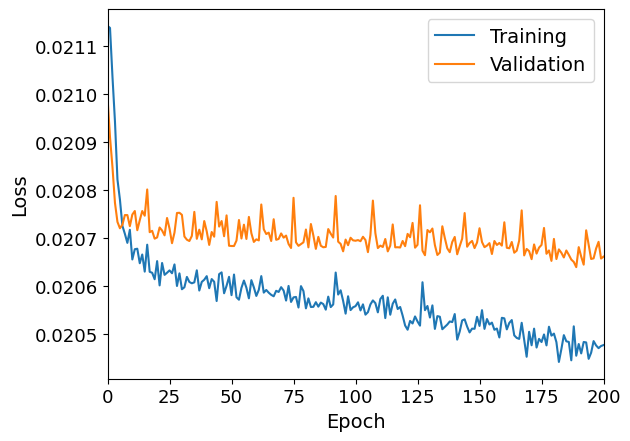

In [24]:
# Graph loss for training and validation
figure1 = plt.gcf()
plt.plot(LossAccDF['Epoch'], LossAccDF['TrainLoss'])
plt.plot(LossAccDF['Epoch'], LossAccDF['ValLoss'])
plt.xlim([0,epochs])
plt.xlabel('Epoch', fontsize=14)
plt.ylabel('Loss', fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.tick_params(axis='x', labelsize=13)
plt.tick_params(axis='y', labelsize=13)
plt.legend(['Training', 'Validation'], fontsize=14)

# Save figure into figure bank
figure1.savefig(Path(fig_bank_path+Set+'_Loss.png'), dpi=300)

### Fig 2: training and validation accuracy

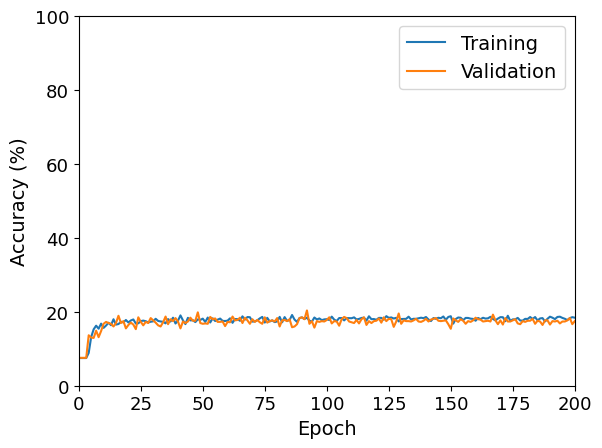

In [25]:
# Graph accuracy for training and validation
figure2 = plt.gcf()
plt.plot(LossAccDF['Epoch'], (LossAccDF['TrainAcc'])*100)
plt.plot(LossAccDF['Epoch'], (LossAccDF['ValAcc'])*100)
plt.xlabel('Epoch', fontsize=14)
plt.ylabel('Accuracy (%)', fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.tick_params(axis='x', labelsize=13)
plt.tick_params(axis='y', labelsize=13)
plt.xlim([0,epochs])
plt.ylim([0,100])
plt.legend(['Training', 'Validation'], fontsize=14)

# Save figure into figure bank
figure2.savefig(Path(fig_bank_path+Set+'_Acc.png'), dpi=300)

### Fig 3: confusion matrices

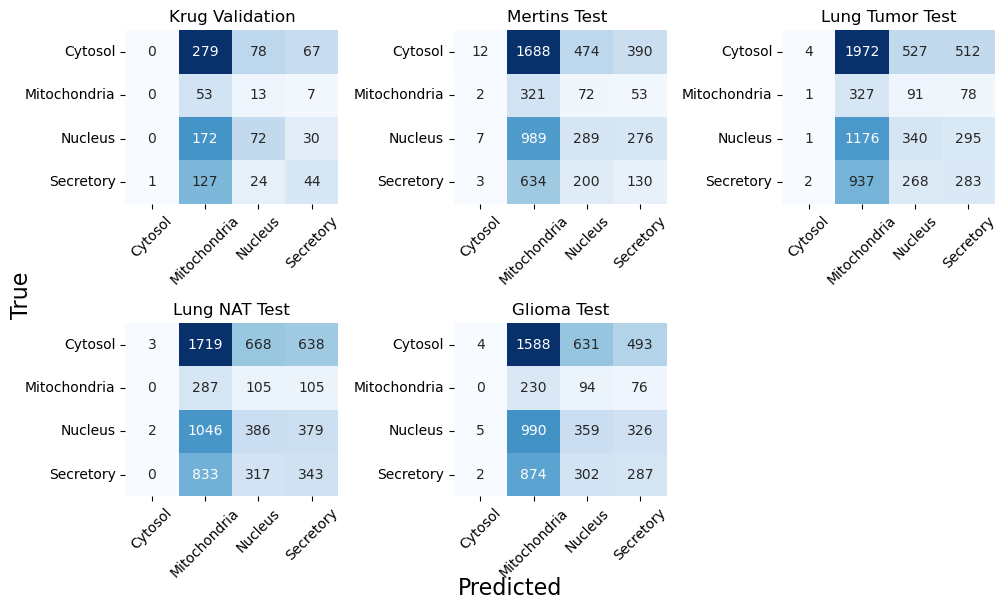

<Figure size 640x480 with 0 Axes>

In [26]:
# Set seed
set_seed(Seed)

# Get the confusion matrix and precision and recall for the validation loader and all test loaders
cf_matrix_val, precision_val, recall_val, macro_f1_val, mcc_val = calculate_metrics(val_loader, model)
cf_matrix_M, precision_M, recall_M, macro_f1_M, mcc_M = calculate_metrics(M_test_loader, model)
cf_matrix_lung_tumor, precision_lung_tumor, recall_lung_tumor, macro_f1_lung_tumor, mcc_lung_tumor = calculate_metrics(lung_tumor_test_loader, model)
cf_matrix_lung_nat, precision_lung_nat, recall_lung_nat, macro_f1_lung_nat, mcc_lung_nat = calculate_metrics(lung_nat_test_loader, model)
cf_matrix_glioma, precision_glioma, recall_glioma, macro_f1_glioma, mcc_glioma = calculate_metrics(glioma_test_loader, model)

# Put them into a list
cf_matrices = [cf_matrix_val, cf_matrix_M, cf_matrix_lung_tumor, cf_matrix_lung_nat, cf_matrix_glioma]
titles = ['Krug Validation', 'Mertins Test ', 'Lung Tumor Test', 'Lung NAT Test', 'Glioma Test']

# Plot the confusion matrices
plot_confusion_matrices(cf_matrices, labels=int_to_label.values(), title=titles)

# Save figure into figure bank
figure3 = plt.gcf()
figure3.savefig(Path(fig_bank_path+Set+'_Confusion_Matrices.png'), dpi=300)

### Fig 4: macro F1 and MCC

In [27]:
PrecisionRecallDF

,Epoch,Class,Precision,Recall,Macro F1,MCC
0,0.0,0.0,0.000000,0.000000,0.035096,0.000000
1,0.0,1.0,0.075491,1.000000,0.035096,0.000000
2,0.0,2.0,0.000000,0.000000,0.035096,0.000000
3,0.0,3.0,0.000000,0.000000,0.035096,0.000000
4,1.0,0.0,0.000000,0.000000,0.035096,0.000000
...,...,...,...,...,...,...
799,199.0,3.0,0.293103,0.260204,0.174367,0.066539
800,200.0,0.0,0.000000,0.000000,0.179687,0.066375
801,200.0,1.0,0.083994,0.726027,0.179687,0.066375
802,200.0,2.0,0.385027,0.262774,0.179687,0.066375


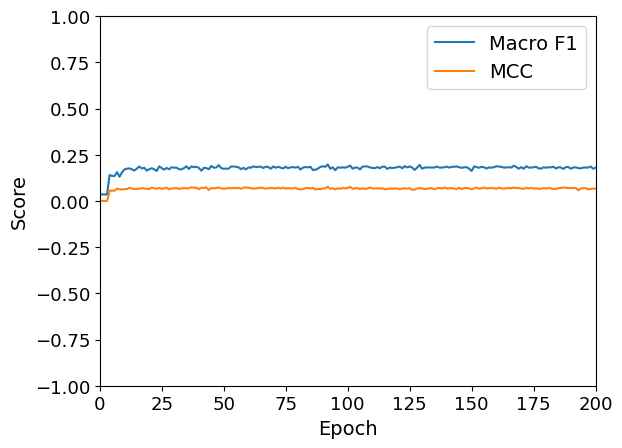

In [28]:
# Plot macro F1 and MCC score in PrecisionRecallDF vs epoch
figure4 = plt.gcf()
plt.plot(PrecisionRecallDF['Epoch'], PrecisionRecallDF['Macro F1'])
plt.plot(PrecisionRecallDF['Epoch'], PrecisionRecallDF['MCC'])
plt.xlabel('Epoch', fontsize=14)
plt.ylabel('Score', fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.tick_params(axis='x', labelsize=13)
plt.tick_params(axis='y', labelsize=13)
plt.xlim([0,epochs])
plt.ylim([-1,1])
plt.legend(['Macro F1', 'MCC'], fontsize=14)
# Save figure into figure bank
figure4.savefig(Path(fig_bank_path+Set+'_MacroF1_MCC.png'), dpi=300)
# Save the model

### Fig 5: Precision and recall of validation and testing

In [29]:
def compute_bootstrap_ci(dataloader, num_iterations=10000, confidence_percentile=95):
    """
    Computes precision, recall, and F1-score confidence intervals using bootstrapping.

    Parameters:
    - dataloader: DataLoader containing the dataset (can be any dataset, not specifically validation)
    - num_iterations: Number of bootstrap iterations (default: 10000)
    - confidence_percentile: The percentile for confidence intervals (default: 95)

    Returns:
    - f1_final_array: The confidence interval values for F1-score
    """
    
    # Initialize a Counter to store class counts in the dataset
    class_counts = Counter()

    # Iterate over the DataLoader to count occurrences of each class
    for _, labels in dataloader:
        class_counts.update(labels.numpy())

    # Sort the class distribution and convert counts to percentages
    class_names = ['Cytosolic', 'Mitochondrial', 'Nuclear', 'Secretory']
    total_samples = len(dataloader.dataset)

    class_distribution = [(class_names[label], round(count / total_samples * 10000)) for label, count in sorted(class_counts.items())]

    # Create a vector of 10,000 true labels based on the class distribution
    true_labels_vector = np.array([class_name for class_name, count in class_distribution for _ in range(count)])
    random.shuffle(true_labels_vector)

    # Sample predicted labels randomly from true_labels_vector
    pred_labels_vector = np.random.choice(true_labels_vector, size=10000, replace=True)

    # Ensure both vectors have the same shape
    assert true_labels_vector.shape == pred_labels_vector.shape

    # Initialize arrays for storing precision, recall, and F1 scores
    precision_array = np.zeros((len(class_counts), num_iterations))
    recall_array = np.zeros((len(class_counts), num_iterations))
    f1_array = np.zeros((len(class_counts), num_iterations))

    # Perform bootstrapping by shuffling labels and computing metrics
    for i in range(num_iterations):
        # Shuffle the true and predicted labels independently
        #shuffled_true = np.random.permutation(true_labels_vector)
        shuffled_pred = np.random.permutation(pred_labels_vector)

        # Compute precision and recall for each class
        precision = precision_score(shuffled_true, shuffled_pred, average=None, zero_division=0)
        recall = recall_score(shuffled_true, shuffled_pred, average=None, zero_division=0)

        # Compute F1-score, handling division by zero safely
        f1 = np.where((precision + recall) == 0, 0, 
                      2 * (precision * recall) / (precision + recall))

        # Store results in the respective arrays
        precision_array[:, i] = precision
        recall_array[:, i] = recall
        f1_array[:, i] = f1

    # Sort each row in the arrays from smallest to largest
    f1_array_sorted = np.sort(f1_array, axis=1)

    # Extract the confidence percentile value (e.g., 95th percentile)
    ci_index = int(num_iterations * (confidence_percentile / 100)) - 1  # Zero-based index

    f1_final_array = f1_array_sorted[:, ci_index]

    return f1_final_array

In [30]:
# val_ci_f1_array = compute_bootstrap_ci(val_dataloader, num_iterations=10000, confidence_percentile=95)
# M_ci_f1_array = compute_bootstrap_ci(M_test_dataloader, num_iterations=10000, confidence_percentile=95)
# JM_ci_f1_array = compute_bootstrap_ci(JM_test_dataloader, num_iterations=10000, confidence_percentile=95)

In [31]:
val_ci_f1_array = np.array([0.43314056, 0.09879518, 0.30857335, 0.20966921])

In [32]:
M_ci_f1_array = np.array([0.45134342, 0.0976801 , 0.29827316, 0.20153805])

In [33]:
JM_ci_f1_array = np.array([0.44705614, 0.09885473, 0.29755245, 0.20585948])

/tmp/ipykernel_18777/2350277031.py:50: RuntimeWarning: divide by zero encountered in divide
  y_right = f1_score * x_right / (2 * x_right - f1_score)


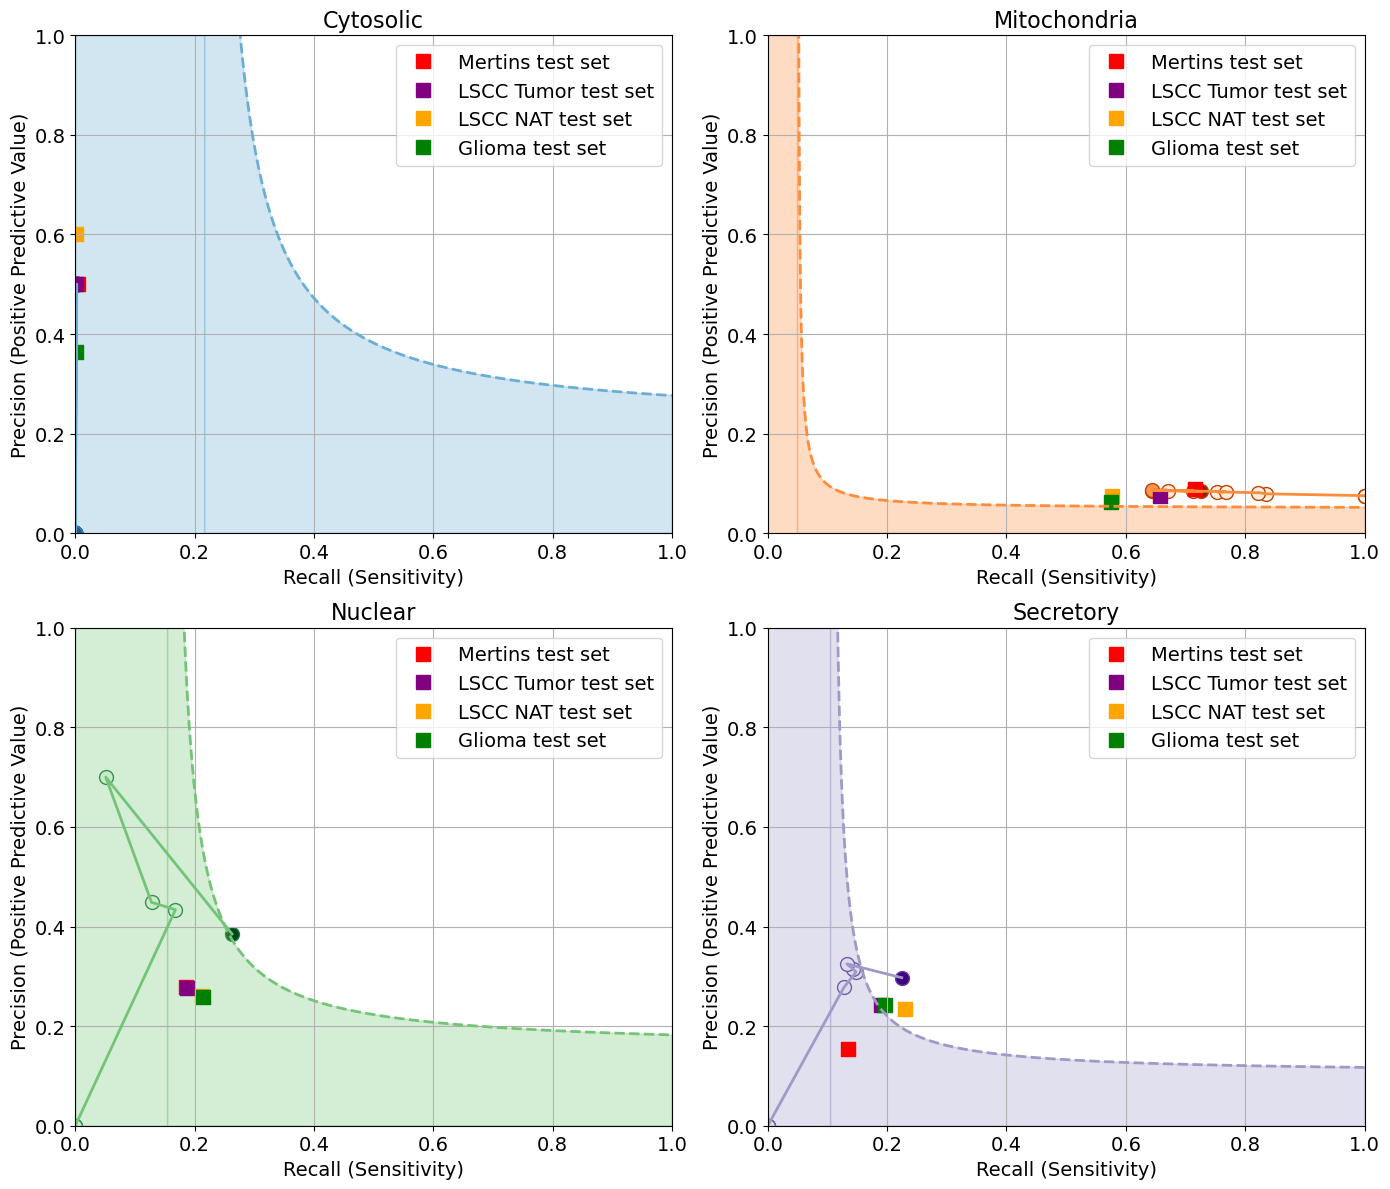

<Figure size 640x480 with 0 Axes>

In [34]:
set_seed(Seed)
fig, axes = plt.subplots(2, 2, figsize=(14, 12))
axes = axes.flatten()
compartment_class = ['Cytosolic', 'Mitochondria', 'Nuclear', 'Secretory']
colormaps = [cm.Blues, cm.Oranges, cm.Greens, cm.Purples]

# Function to filter improvement epochs using precision as the guide
def filter_improvement_epochs(df):
    improved_epochs = []
    for class_label in df['Class'].unique():
        class_df = df[df['Class'] == class_label].copy()
        class_df = class_df.sort_values(by='Epoch')
        max_precision = float('-inf')
        
        for _, row in class_df.iterrows():
            if row['Precision'] >= max_precision:
                max_precision = row['Precision']
                improved_epochs.append(row)
    
    # Ensure starting (0) and ending (last) epochs are included
    start_epoch = df[df['Epoch'] == 0]
    last_epoch = df[df['Epoch'] == df['Epoch'].max()]
    
    return pd.concat([start_epoch, pd.DataFrame(improved_epochs), last_epoch]).drop_duplicates()

# Get improvement epochs based on precision
improved_epochs_df = filter_improvement_epochs(PrecisionRecallDF)

for i, f1_score in enumerate(np.array([0.43314056, 0.09879518, 0.30857335, 0.20966921])):
    # Select the subplot
    ax = axes[i]

    # Filter the metrics for the current class
    class_metrics = improved_epochs_df[improved_epochs_df['Class'] == i]
    # Normalize epoch for color mapping
    norm = plt.Normalize(class_metrics['Epoch'].min(), class_metrics['Epoch'].max())

    # Scatter plot with gradient color based on epoch
    for idx, row in class_metrics.iterrows():
        color = colormaps[i](norm(row['Epoch']))
        edge_color = colormaps[i](0.8)
        ax.scatter(row['Recall'], row['Precision'], s=100, color=color, edgecolors=edge_color, linewidths=1)

    # Connect the dots with colored lines
    ax.plot(class_metrics['Recall'], class_metrics['Precision'], color=colormaps[i](0.5), linewidth=2)

    # Plot the F1 score curve
    x_left = np.linspace(0, (f1_score / 2), 10000)
    x_right = np.linspace((f1_score / 2), 1, 10000)
    y_right = f1_score * x_right / (2 * x_right - f1_score)
    ax.plot(x_right, y_right, color=colormaps[i](0.5), linestyle='--', linewidth=2)
    # Fill the area on the left of the curve
    ax.fill_between(x_left, 0, 1, color=colormaps[i](0.5), alpha=0.3)
    ax.fill_between(x_right, 0, y_right, color=colormaps[i](0.5), alpha=0.3)

    # Add in a scatter dot to label the precision and recall of testing set
    ax.scatter(recall_M[i], precision_M[i], s=100, color='red', edgecolors='red', linewidths=1, marker='s')
    ax.scatter(recall_lung_tumor[i], precision_lung_tumor[i], s=100, color='purple', edgecolors='purple', linewidths=1, marker='s')
    ax.scatter(recall_lung_nat[i], precision_lung_nat[i], s=100, color='orange', edgecolors='orange', linewidths=1, marker='s')
    ax.scatter(recall_glioma[i], precision_glioma[i], s=100, color='green', edgecolors='green', linewidths=1, marker='s')

    # Aesthetics
    ax.tick_params(axis='x', labelsize=14)
    ax.tick_params(axis='y', labelsize=14)
    ax.set_title(compartment_class[i], fontsize=16)
    ax.set_xlim([0, 1])
    ax.set_ylim([0, 1])
    ax.set_xlabel('Recall (Sensitivity)', fontsize=14)
    ax.set_ylabel('Precision (Positive Predictive Value)', fontsize=14)
    ax.grid(True)

    # Create custom legend handles
    mertins_handle = mlines.Line2D([], [], color='red', marker='s', linestyle='None', markersize=10, label='Mertins test set')
    lung_tumor_handle = mlines.Line2D([], [], color='purple', marker='s', linestyle='None', markersize=10, label='LSCC Tumor test set')
    lung_nat_handle = mlines.Line2D([], [], color='orange', marker='s', linestyle='None', markersize=10, label='LSCC NAT test set')
    glioma_handle = mlines.Line2D([], [], color='green', marker='s', linestyle='None', markersize=10, label='Glioma test set')

    # Add the legend to the plot
    ax.legend(handles=[mertins_handle, lung_tumor_handle, lung_nat_handle, glioma_handle], loc='upper right', fontsize=14)

plt.tight_layout()
plt.show()

# Save figure into figure bank
figure5 = plt.gcf()
figure5.savefig(Path(fig_bank_path+Set+'_Precision_Recall_F1curve.png'), dpi=300)
# Save the model

In [35]:
# export dataframes
LossAccDF.to_excel(Path(fig_bank_path + Set+ f'LossAccDF.xlsx'), index=False)
PrecisionRecallDF.to_excel(Path(fig_bank_path + Set+ f'PrecisionRecallDF.xlsx'), index=False)